# Dorsal Rim Specialisation
- Visualizes and performs hypothesis tests on certain connection counts and optical parameters for a group of ommatidia in the dorsal rim area (DRA) and a group outside the dorsal rim area (Non-DRA or NDRA) 

In [1]:
%load_ext autoreload
%autoreload 2
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
#from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

from src.utils import index_by_om
from vis.fig_tools import linear_cmap, subtype_cm
from vis.hex_lattice import hexplot

import matplotlib as mpl
mpl.rc('font', size=14)

In [2]:
# Each ommatidia's onnection counts
tp = '200914'
data_dir = f'~/Data/{tp}_lamina'
cxdf = pd.read_pickle(os.path.join(os.path.expanduser(data_dir), f'{tp}_cxdf.pickle'))
widedf = index_by_om(cxdf)  # pivot so that each row is an ommatidium with columns for each possible connection count

# Anastasia's measurements for each Rhabdom's twist
twistdf = pd.read_csv('~/Data/lamina_additional_data/1911_am_rhab_twist.csv', index_col=0)

# Retinotopic regions
om_list = [str(o) for o in widedf.index]
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [str(o) for o in widedf.index if o not in dra_om]

cm = subtype_cm()


In [3]:
r7_inputs = widedf.filter(regex='->R7$').sum(axis=1)
r7p_inputs = widedf.filter(regex='->R7p$').sum(axis=1)
r8_inputs = widedf.filter(regex='->R8$').sum(axis=1)

## Lamina connectome reveals different R7 wiring patterns in the dorsal area of the retinotopic field

## DRA ommatidia receive significantly more inputs to R7 than Non-DRA ommatidia
Two sample Mann-Whitney U test (one tailed)

$$H_{0}: P(x_{i} > y_{j}) <= 1/2$$

$$H_{1}: P(x_{i} > y_{j}) > 1/2$$

Where x is the number of R7 inputs observed in DRA ommatidium i, and y is the number of R7 inputs in NDRA ommatidium j

In [4]:
s, p, = mannwhitneyu(r7_inputs[dra_om], r7_inputs[ndra_om], alternative='greater')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .6f}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: DRA R7 receive more inputs")

###### RESULTS ######
Test statistic: 190.0, p-value:  0.000007
Reject null: DRA R7 receive more inputs


## Angular displacement of rhabdom microvilli is significantly smaller in DRA ommatidia 
Two sample Mann-Whitney U test (one tailed)

$$H_{0}: P(x_{i} < y_{j}) <= 1/2$$

$$H_{1}: P(x_{i} < y_{j}) > 1/2$$

Where x is the distal - proximal angular difference of the rhabdom of ommatidium i, and y is the distal - proximal angular difference of the rhabdom of ommatidium j

In [5]:
s, p = mannwhitneyu(twistdf.loc[dra_om], twistdf.loc[ndra_om], alternative='less')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .6f}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: DRA rhabdoms twist at a smaller degree")

###### RESULTS ######
Test statistic: 15.0, p-value:  0.000132
Reject null: DRA rhabdoms twist at a smaller degree


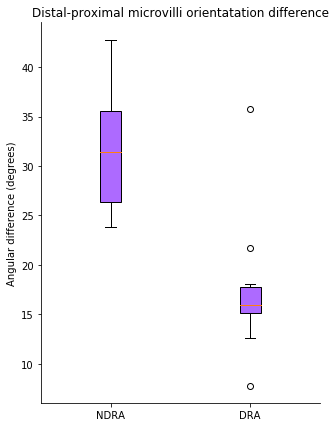

In [6]:
fig, ax = plt.subplots(1, figsize=[5, 7])

data = [twistdf.loc[ndra_om].to_numpy(), twistdf.loc[dra_om].to_numpy()]
ax.set_title("Distal-proximal microvilli orientatation difference")

bp = ax.boxplot(data, patch_artist=True, vert=True)
ax.set_xticklabels(["NDRA", "DRA"])
ax.set_ylabel("Angular difference (degrees)")
bp["boxes"][0].set_facecolor(cm['R7'])
bp["boxes"][1].set_facecolor(cm['R7'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

fig.savefig("/mnt/home/nchua/Dropbox/200610_r7r7p-twist.svg")

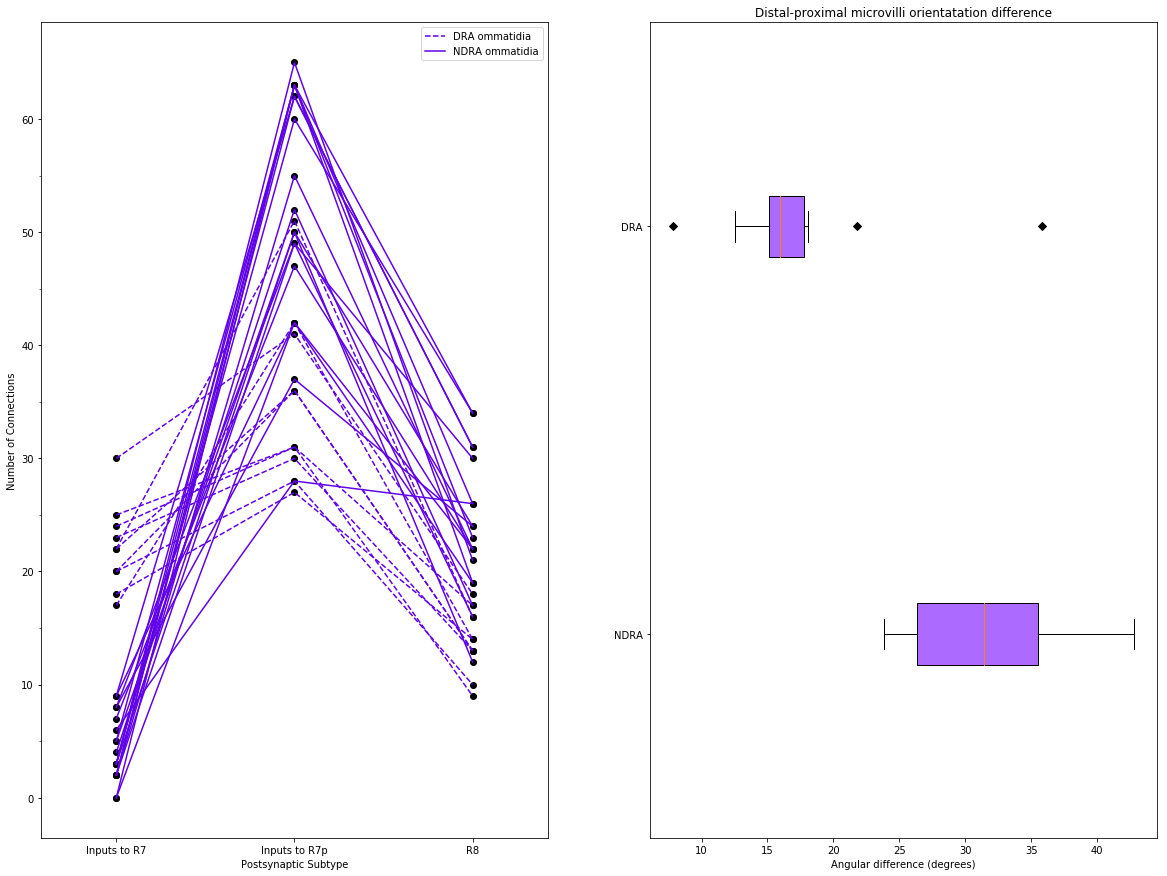

In [7]:
fig, ax = plt.subplots(1, 2, figsize=[20, 15])
ax[0].margins(x=0.2)
ax[0].set_yticks(ticks=np.arange(0, r7p_inputs.max(), 5), minor=True)
ax[0].set_xlabel("Postsynaptic Subtype")
ax[0].set_ylabel("Number of Connections")

for o in om_list:
    if o in dra_om:
        linestyle = '--'
    else:
        linestyle = '-'
        
#     ax[0].plot(['Inputs to R7', 'Inputs to R7p'], [r7_inputs[o], r7p_inputs[o]], color=cm['R7p'], linestyle=linestyle)
#     ax[0].scatter(['Inputs to R7', 'Inputs to R7p'], [r7_inputs[o], r7p_inputs[o]], color='k')
    ax[0].plot(['Inputs to R7', 'Inputs to R7p', 'R8'], [r7_inputs[o], r7p_inputs[o], r8_inputs[o]], color=cm['R7p'], linestyle=linestyle)
    ax[0].scatter(['Inputs to R7', 'Inputs to R7p', 'R8'], [r7_inputs[o], r7p_inputs[o], r8_inputs[o]], color='k')
lines = [Line2D([0], [0], color=cm['R7p'], linestyle='--'),
        Line2D([0], [0], color=cm['R7p'], linestyle='-')]
ax[0].legend(lines, ['DRA ommatidia', 'NDRA ommatidia'])

# ~~~~~~~~~~~~~~~

data = [twistdf.loc[ndra_om].to_numpy(), twistdf.loc[dra_om].to_numpy()]
ax[1].set_title("Distal-proximal microvilli orientatation difference")

bp = ax[1].boxplot(data, 0, 'kD', 0, patch_artist=True)
ax[1].set_yticklabels(["NDRA", "DRA"])
ax[1].set_xlabel("Angular difference (degrees)")
bp["boxes"][0].set_facecolor(cm['R7'])
bp["boxes"][1].set_facecolor(cm['R7'])

plt.show()

fig.savefig("/mnt/home/nchua/Dropbox/200615_r7r7p_inputs_rotation.pdf")

In [8]:
twistdf.mean()

rhabdom_twist    26.791995
dtype: float64

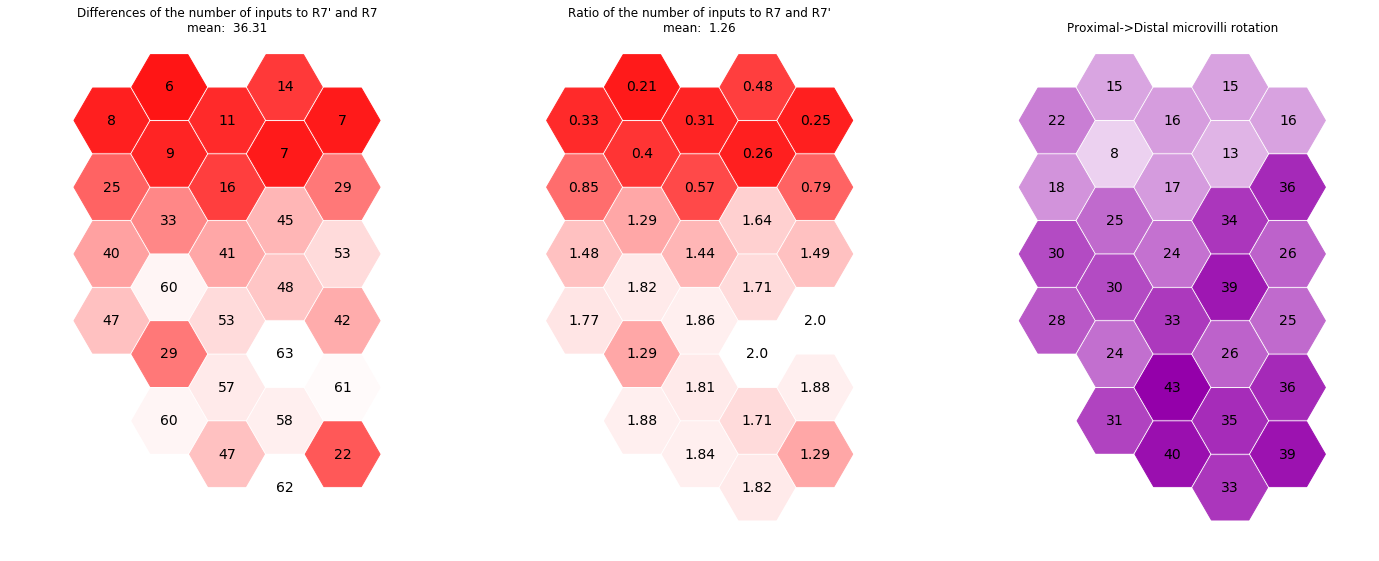

In [9]:
# Ret map of R7p - R7 inputs


fig, ax = plt.subplots(1, 3, figsize=(24, 15))

diff = r7p_inputs - r7_inputs
inv_cm = linear_cmap(n_vals=50, max_colour='#ffffff', min_colour='r')
max_val = diff.max()
node_data = {om: {'label': str(int(v)),
                 'colour': inv_cm(v/max_val)} for om, v in diff.to_dict().items()}
hexplot(node_data, ax=ax[0])
ax[0].set_title(f"Differences of the number of inputs to R7' and R7\nmean: {diff.mean(): .2f}")

#################
ratio = 2 * abs(r7_inputs-r7p_inputs)/(r7_inputs + r7p_inputs)
max_val = ratio.max()

#red_cm = inv_cm = linear_cmap(n_vals=50, max_colour='r', min_colour='#ffffff')
node_data = {om:{'label': str(np.round(v, decimals=2)),
                'colour': inv_cm(v/max_val)} for om, v in ratio.to_dict().items()}
hexplot(node_data=node_data, ax=ax[1])

ax[1].set_title(f"Ratio of the number of inputs to R7 and R7'\nmean: {ratio.mean(): .2f}")


#################
lincm = linear_cmap(n_vals=100, max_colour=cm['R8'])
max_val = twistdf.max()
tw = twistdf.to_dict()['rhabdom_twist']
node_data = {om: {'colour': lincm(angle/max_val)[0],
                'label': str(round(angle))} for om, angle in tw.items()}


hexplot(node_data=node_data, ax=ax[2])
ax[2].set_title(f"Proximal->Distal microvilli rotation")

plt.show()
fig.savefig("/mnt/home/nchua/Dropbox/200615_r7r7p_ratio_rotation.pdf")


In [10]:
twistdf.to_dict()

{'rhabdom_twist': {'E7': 21.751851851851804,
  'E6': 18.0949367088608,
  'E5': 30.106172839506197,
  'E4': 27.848148148148102,
  'D7': 15.0506172839506,
  'D6': 7.80506329113924,
  'D5': 24.8367088607595,
  'D4': 30.3308641975309,
  'D3': 23.988888888888898,
  'D2': 31.4271604938272,
  'C6': 16.3,
  'C5': 16.734567901234602,
  'C4': 23.856790123456804,
  'C3': 32.953086419753106,
  'C2': 42.7779220779221,
  'C1': 39.908641975308704,
  'B6': 15.4125,
  'B5': 12.566666666666698,
  'B4': 33.7716049382716,
  'B3': 38.6555555555555,
  'B2': 26.407407407407398,
  'B1': 35.4493827160494,
  'B0': 33.4456790123457,
  'A5': 15.555,
  'A4': 35.807594936708895,
  'A3': 26.228395061728396,
  'A2': 24.907407407407398,
  'A1': 35.6275,
  'A0': 39.361728395061704}}

{'E7': {'colour': array([0.78807685, 0.49494949, 0.83164983, 1.        ]), 'label': '22'}, 'E6': {'colour': array([0.82198455, 0.57575758, 0.85858586, 1.        ]), 'label': '18'}, 'E5': {'colour': array([0.70330759, 0.29292929, 0.76430976, 1.        ]), 'label': '30'}, 'E4': {'colour': array([0.7244999 , 0.34343434, 0.78114478, 1.        ]), 'label': '28'}, 'D7': {'colour': array([0.85165379, 0.64646465, 0.88215488, 1.        ]), 'label': '15'}, 'D6': {'colour': array([0.92370766, 0.81818182, 0.93939394, 1.        ]), 'label': '8'}, 'D5': {'colour': array([0.75416914, 0.41414141, 0.8047138 , 1.        ]), 'label': '25'}, 'D4': {'colour': array([0.70330759, 0.29292929, 0.76430976, 1.        ]), 'label': '30'}, 'D3': {'colour': array([0.76264607, 0.43434343, 0.81144781, 1.        ]), 'label': '24'}, 'D2': {'colour': array([0.6905922 , 0.26262626, 0.75420875, 1.        ]), 'label': '31'}, 'C6': {'colour': array([0.8389384 , 0.61616162, 0.87205387, 1.        ]), 'label': '16'}, 'C5': {'co

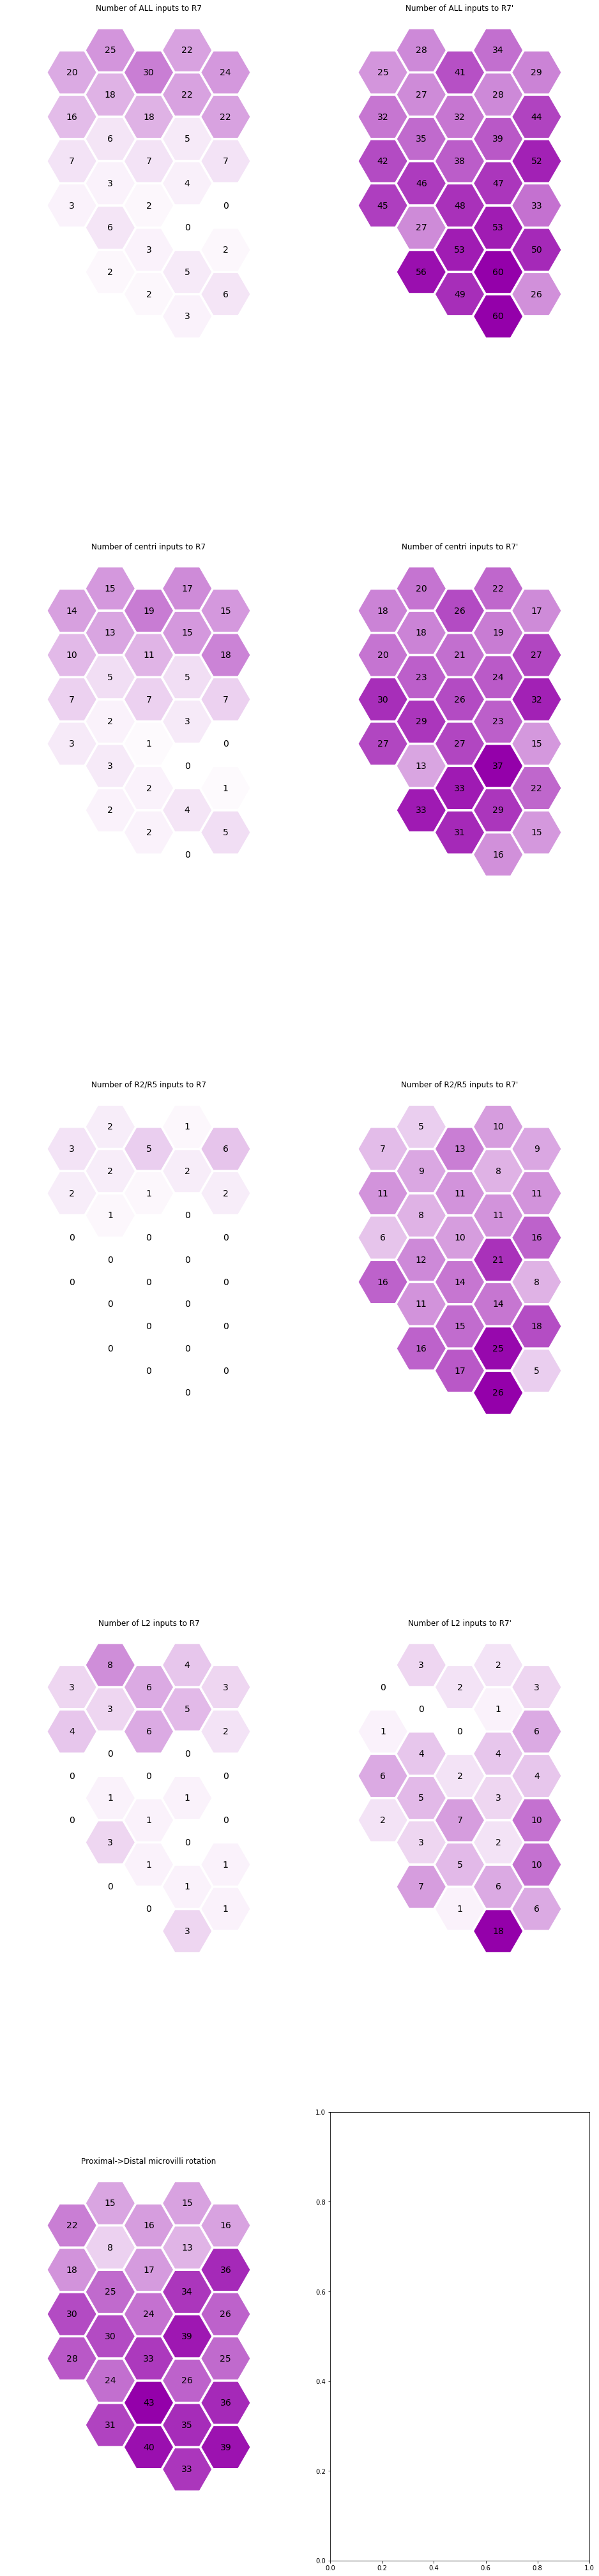

TypeError: Must pass either `items`, `like`, or `regex`

In [11]:
# Retinotopic map
fig, ax = plt.subplots(5, 2, figsize=[16, 15*5])#maybe 20*4
lincm = linear_cmap(n_vals=100, max_colour=cm['R8'])

# ALL 
r7_inputs = widedf.filter(items=['centri->R7', 'LMC_2->R7', 'R2R5->R7']).sum(axis=1)
r7p_inputs = widedf.filter(items=['centri->R7p', 'LMC_2->R7p', 'R2R5->R7p']).sum(axis=1)
max_val= max(r7_inputs.max(), r7p_inputs.max())


node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7_inputs.items()}
hexplot(node_data=node_data, ax=ax[0, 0])
ax[0, 0].set_title("Number of ALL inputs to R7")

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7p_inputs.items()}
hexplot(node_data=node_data, ax=ax[0, 1])
ax[0, 1].set_title("Number of ALL inputs to R7'")

# Centri
r7_inputs = widedf.filter(items=['centri->R7']).sum(axis=1)
r7p_inputs = widedf.filter(items=['centri->R7p']).sum(axis=1)
max_val= max(r7_inputs.max(), r7p_inputs.max())

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7_inputs.items()}
hexplot(node_data=node_data, ax=ax[1, 0])
ax[1, 0].set_title("Number of centri inputs to R7")

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7p_inputs.items()}
hexplot(node_data=node_data, ax=ax[1, 1])
ax[1, 1].set_title("Number of centri inputs to R7'")

# R2R5
r7_inputs = widedf.filter(items=['R2R5->R7']).sum(axis=1)
r7p_inputs = widedf.filter(items=['R2R5->R7p']).sum(axis=1)
max_val= max(r7_inputs.max(), r7p_inputs.max())

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7_inputs.items()}
hexplot(node_data=node_data, ax=ax[2, 0])
ax[2, 0].set_title("Number of R2/R5 inputs to R7")

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7p_inputs.items()}
hexplot(node_data=node_data, ax=ax[2, 1])
ax[2, 1].set_title("Number of R2/R5 inputs to R7'")

# L2
r7_inputs = widedf.filter(items=['LMC_2->R7']).sum(axis=1)
r7p_inputs = widedf.filter(items=['LMC_2->R7p']).sum(axis=1)
max_val= max(r7_inputs.max(), r7p_inputs.max())

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7_inputs.items()}
hexplot(node_data=node_data, ax=ax[3, 0])
ax[3, 0].set_title("Number of L2 inputs to R7")

node_data = {k: {'colour': lincm(v/max_val),
                'label': str(int(v))} for k, v in r7p_inputs.items()}
hexplot(node_data=node_data, ax=ax[3, 1])
ax[3, 1].set_title("Number of L2 inputs to R7'")

# Rhabdom twist
max_val = twistdf.max()
tw = twistdf.to_dict()['rhabdom_twist']
node_data = {om: {'colour': lincm(angle/max_val)[0],
                 'label': str(round(angle))} for om, angle in tw.items()}
print(node_data)
hexplot(node_data=node_data, ax=ax[4, 0])
ax[4, 0].set_title("Proximal->Distal microvilli rotation")

plt.show()

### DIFF
diff = widedf.filter() - r7_inputs

inv_cm = linear_cmap(n_vals=50, max_colour='#ffffff', min_colour='r')
max_val = diff.max()

fig, ax = plt.subplots(2, 1, figsize=(16, 15))

node_data = {om: {'label': str(int(v)),
                 'colour': inv_cm(v/max_val)} for om, v in diff.to_dict().items()}
hexplot(node_data, ax=ax[0])
ax.set_title("Differences in the number of synaptic inputs to R7' and R7")






fig.savefig("/mnt/home/nchua/Dropbox/200614_r7r7p_compositewangle.pdf")

In [ ]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
df_dra = homevecs.filter(items=dra_om, axis=0).filter(like='->R7')
#df_dra = df_dra.loc[:, [i for i in df_allom.columns if (i[0] != 'R')]]
dra_corr = df_dra.corr().dropna(axis=1)
dra_corr = dra_corr.loc[[i for i in df_allom.columns if (i[0] != 'R')], 
                        [i for i in df_allom.columns if (i[0] != 'R')]]

row_colors = [cm[x.split('->')[0]] for x in dra_corr.index]
col_colors = [cm[x.split('->')[1]] for x in dra_corr.columns]
sns.clustermap(dra_corr, xticklabels=dra_corr.columns, yticklabels=dra_corr.index, 
               row_colors=row_colors, col_colors=col_colors, linewidth=0.1,
               figsize=[11, 11], metric='cosine', 
               cmap='vlag', vmax=1.0, vmin=-1.0)

## Relationship between connection counts and optical measurements

In [ ]:
'''
def lin_model_intercept0(x, y):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    return LinearRegression(fit_intercept=False).fit(x, y)

fig, ax = plt.subplots(1)
print([len(widedf['centri->R7']), len(twistdf.loc[widedf.index])])
x = widedf['centri->R7']
y = twistdf.loc[widedf.index]   # TODO: change col name

xticks = np.arange(0, x.max()).reshape(-1, 1)
r7_v_twist = lin_model_intercept0(x, y)
ax.plot(xticks, r7_v_twist.predict(xticks))
ax.set_title(f"R^2 = {r7_v_twist.score(widedf['centri->R7'].to_numpy().reshape(-1, 1), twistdf.loc[om_list])}")
'''

In [ ]:
fig, ax = plt.subplots(1, figsize=[15, 15])
ax.set_xlabel('Number of R7 inputs')
ax.set_ylabel('Rhabdom angular difference (degrees)')

#display(widedf.filter(regex='->R7$'))
total_r7 = widedf.filter(regex='->R7$').sum(axis=1)
total_r7 = total_r7.loc[total_r7.index != 'C6']

x = np.asarray(total_r7).reshape(-1, 1)
y = np.asarray(twistdf.loc[total_r7.index])
model = LinearRegression().fit(x, y)
xticks = np.arange(0, total_r7.max()).reshape(-1, 1)

ax.plot(xticks, model.predict(xticks), label=f"R^2 = {model.score(x, y): .3f}")
ax.scatter(x, y)
ax.legend()
